In [21]:
from __future__ import print_function
import sys
import os
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import logging
import cv2
import scipy.ndimage as nd

In [22]:
ls_image =sorted(glob.glob('./*_NAT*/*.nii'))

Tumeurs difficiles:
0,8,32,140, 200, 270,273, 360
Chercher la plus grande composante connexe. Pénaliser la distance vs centre? (pour pénaliser le second cercle!)

### Lire une image et afficher sa bonne slice

In [23]:
def slice_show(image_num):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    print(image.GetSize())
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    print(mask.GetSize())
    n_slices = image.GetSize()[2]
    li_good = []
    for slice_num in range(n_slices):
        slice_try = image[:,:,slice_num]
        mask_slice_try = mask[:,:,slice_num]
        lsif = sitk.LabelStatisticsImageFilter()
        lsif.Execute(slice_try, mask_slice_try != 0)
        boundingBox = np.array(lsif.GetBoundingBox(label = 1))
        ndims = np.sum((boundingBox[1::2] - boundingBox[0::2] + 1) > 3)  # UBound - LBound + 1 = Size
        if (sitk.GetArrayFromImage(mask_slice_try != 0).sum() > 0) & (ndims >= 2):
            li_good.append(slice_num)
    if len(li_good) == 0:
        print('No good slices')
        return
    correct_slice = li_good[len(li_good)//2]
    slice_good = image[:,:,correct_slice]
    plt.figure(figsize = (15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(sitk.GetArrayFromImage(slice_good))
    mask_slice_good = mask[:,:,correct_slice]
    plt.subplot(1, 2, 2)
    plt.imshow(sitk.GetArrayFromImage(mask_slice_good))
    print("slice_num:", correct_slice)

(512, 512, 100)
(512, 512, 100)
slice_num: 65


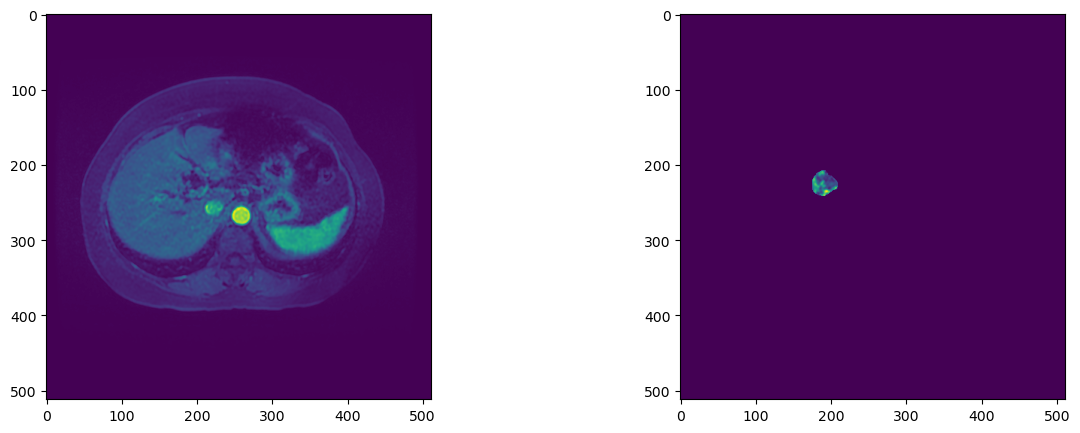

In [24]:
slice_show(4)

### Lire une image et afficher le mask par dessus

In [25]:
def rescale_image(image):
    # Normaliser les valeurs de l'image entre 0 et 1
    image_min = np.min(image)
    image_max = np.max(image)
    image_normalized = (image - image_min) / (image_max - image_min)
    
    # Redimensionner les valeurs normalisées entre 0 et 255
    image_rescaled = (image_normalized * 255).astype(np.uint8)
    
    return image_rescaled

def rescale_image_float(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

In [26]:
def get_good_slice(image_name):
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    n_slices = image.GetSize()[2]
    li_good = []
    for slice_num in range(n_slices):
        slice_try = image[:,:,slice_num]
        mask_slice_try = mask[:,:,slice_num]
        lsif = sitk.LabelStatisticsImageFilter()
        lsif.Execute(slice_try, mask_slice_try != 0)
        boundingBox = np.array(lsif.GetBoundingBox(label = 1))
        ndims = np.sum((boundingBox[1::2] - boundingBox[0::2] + 1) > 3)  # UBound - LBound + 1 = Size
        if (sitk.GetArrayFromImage(mask_slice_try != 0).sum() > 0) & (ndims >= 2):
            li_good.append(slice_num)
    if len(li_good) == 0:
        print('No good slices')
        return
    else:
        return li_good[len(li_good)//2]
    
def get_all_good_slices(image_name):
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    n_slices = image.GetSize()[2]
    li_good = []
    for slice_num in range(n_slices):
        slice_try = image[:,:,slice_num]
        mask_slice_try = mask[:,:,slice_num]
        lsif = sitk.LabelStatisticsImageFilter()
        lsif.Execute(slice_try, mask_slice_try != 0)
        boundingBox = np.array(lsif.GetBoundingBox(label = 1))
        ndims = np.sum((boundingBox[1::2] - boundingBox[0::2] + 1) > 3)  # UBound - LBound + 1 = Size
        if (sitk.GetArrayFromImage(mask_slice_try != 0).sum() > 0) & (ndims >= 2):
            li_good.append(slice_num)
    if len(li_good) == 0:
        print('No good slices')
        return
    else:
        return li_good

On peut même afficher un second masque en plus!

In [27]:
def mask_superpose(image_num, slice_num = None,other_mask = None):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii') 
    mask = sitk.ReadImage(name_mask)
    if slice_num is None:
        slice_num = get_good_slice(image_name)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    mask_slice_good = sitk.GetArrayFromImage(mask[:,:,slice_num]) !=0
    slice_rgb = rescale_image(np.stack([slice_good]*3, axis=-1))
    slice_rgb[:,:,0:3:2] = 0 #Seul canal 1 accepté
    slice_rgb[mask_slice_good == 1,0] = 255
    if other_mask is not None:
        mask_superpose = other_mask !=0
        slice_rgb[mask_superpose == 1,2] = 255
    plt.figure(figsize = (15,5))
    plt.subplot(1, 3, 1)
    plt.imshow(slice_rgb)
    plt.subplot(1, 3, 2)
    plt.imshow(slice_good)
    plt.subplot(1, 3, 3)
    plt.imshow(sitk.GetArrayFromImage(mask[:,:,slice_num]))


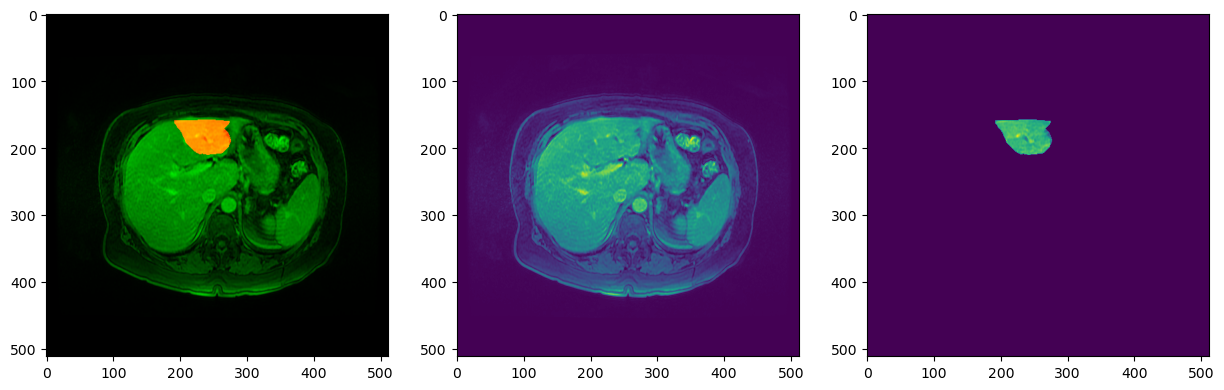

In [44]:
mask_superpose(25)

### Dilatation et érosion d'une image avec opencv

In [29]:
def cercle_image(image_num, slice_num = None,show = False):
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii')
    mask = sitk.ReadImage(name_mask)
    if slice_num is None:
        slice_num = get_good_slice(image_name)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    mask_slice_good = sitk.GetArrayFromImage(mask[:,:,slice_num]) !=0
    mask_slice_good = mask_slice_good.astype(np.uint8)
    mask_dilation_first = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 8)
    mask_dilation_second = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 18)
    # mask_dilation_3 = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 40)
    # mask_dilation_4 = cv2.dilate(mask_slice_good, np.ones((3,3), np.uint8), iterations = 50)
    mask_cercle = mask_dilation_second - mask_dilation_first # + mask_dilation_4 - mask_dilation_3
    
    #histogramme sur variance locale
    
    filtered = rescale_image_float(slice_good).astype(np.float64)
    size = 5
    mean = nd.uniform_filter(filtered, size)
    mean_sq = nd.uniform_filter(filtered**2, size)
    variance = (mean_sq - mean**2)
    #hist, bins = np.histogram(variance[mask_cercle == 1].flatten(), bins = "doane")
    hist, bins = np.histogram(variance[mask_cercle == 1].flatten(), bins = 100)
    #On a les bins maintenant on classe les points
    shape_init = slice_good.shape
    bin_indices = np.digitize(variance.flatten(), bins) - 1
    bin_indices = bin_indices.reshape(shape_init)
    bin_indices[mask_cercle == 0] = -1
    
    #On choisit les bins qu'on garde de l'histogramme: à côté les unes des autres
    pic = np.argmax(hist)
    pic = 0 ##################### ATTENTION C'est car on cherche le minimum de variance
    deja_pris = [pic]
    taille_max = np.sum(mask_cercle == 1)*0.2
    taille = hist[pic]
    nbins = len(hist)
    while taille < taille_max:
        possible = []
        if max(deja_pris) + 1< nbins :
            possible.append(max(deja_pris) + 1)
        if min(deja_pris) > 0:
            possible.append(min(deja_pris) - 1)
        values = [hist[i] for i in possible]
        new_bar = possible[np.argmax(values)]
        deja_pris.append(new_bar)
        taille = taille + hist[new_bar]
    
    bool_matrix = np.isin(bin_indices, deja_pris)
    
    quantile_low_lum =0.5* np.quantile(slice_good.flatten(),0.9)+ 0.5 *np.min(slice_good.flatten()) #pas être dans le noir complet
    cercle_lumineux = bool_matrix & (slice_good > quantile_low_lum)
    
    
    # quantile_inf_cercle = np.quantile(slice_good[mask_cercle == 1].flatten(),0.5)
    # quantile_sup_tumeur = np.quantile(slice_good[mask_slice_good == 1].flatten(),0.7)
    # if quantile_inf_cercle < np.quantile(slice_good[mask_slice_good == 1].flatten(),0.3):
    #     cercle_lumineux = (slice_good > quantile_inf_cercle) & (mask_cercle == 1) & (slice_good < quantile_sup_tumeur)
        
    # else:
    #     cercle_lumineux = (mask_cercle == 1) & (slice_good > quantile_inf_cercle)
    cercle_lumineux = cercle_lumineux.astype(np.uint8)
    if show:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(bool_matrix)
        plt.subplot(1, 3, 2)
        plt.imshow(variance)
        plt.subplot(1, 3, 3)
        plt.hist(variance[mask_cercle == 1].flatten(), bins=bins, edgecolor='black')
        plt.title("Histogramme des valeurs des pixels")
        plt.xlabel("Valeur des pixels")
        plt.ylabel("Fréquence")
        plt.show()
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle)
        mask_superpose(image_num, slice_num = slice_num, other_mask = cercle_lumineux)
    return cercle_lumineux, slice_good, mask_slice_good, mask_cercle
    


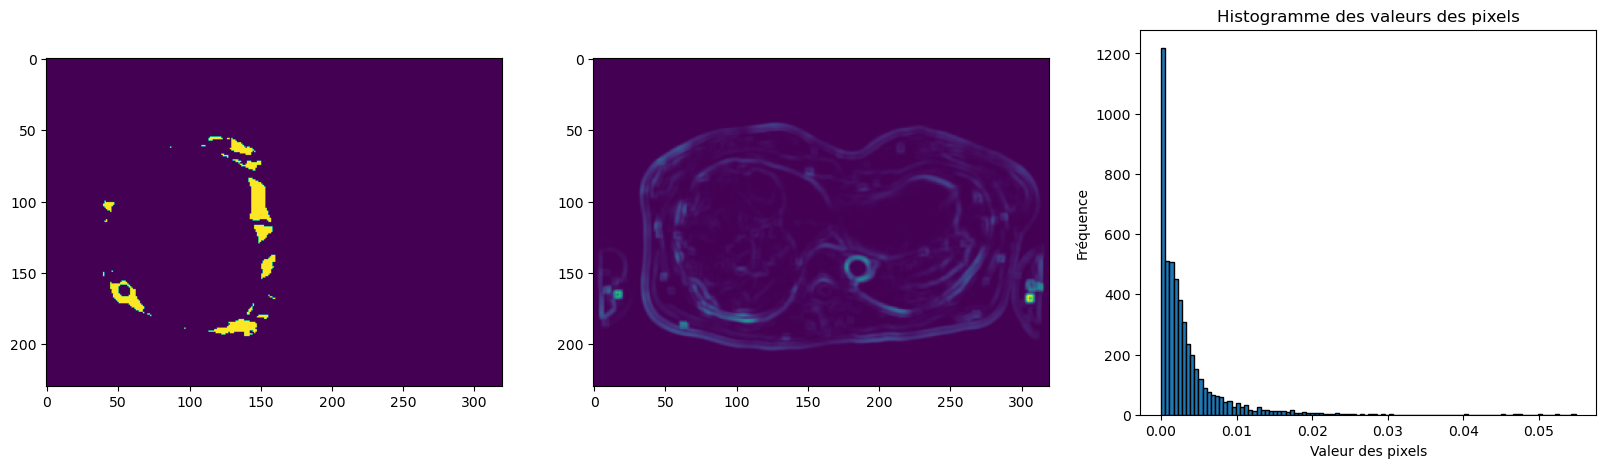

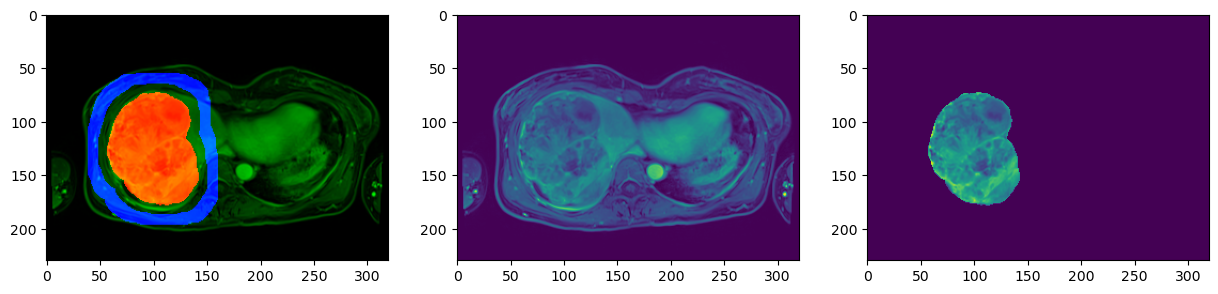

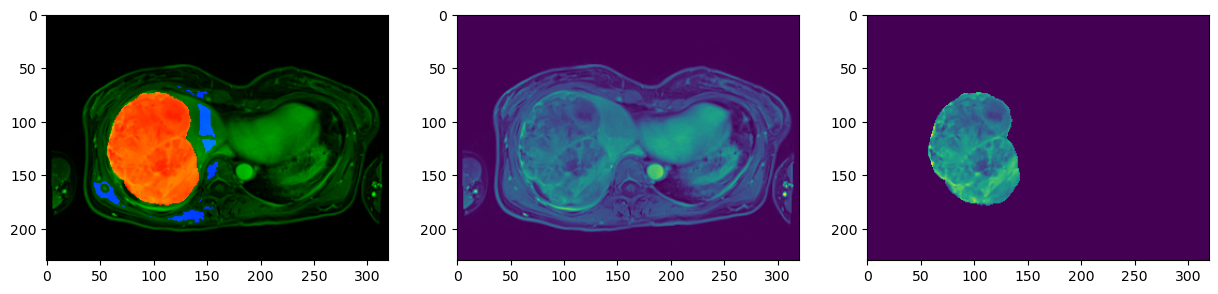

In [30]:
li = cercle_image(140, show = True)


### Avec des composantes connexes

Double critère avec la proximité vs la luminosité de la tumeur

In [31]:
def compute_score(i,components, slice_good, mask_slice_good ,mask_cercle_lumineux, intens_standard, coeff = 0):
    #intens_standard doit standardiser l'écart à l'intensité tumorale. Doit être calculé à partir du max des composantes lumineuses de taille significative.
    component_i = (components == i).astype(np.uint8)
    intens_median_tumor = np.quantile(slice_good[mask_slice_good == 1].flatten(), 0.5)
    size_cercle = np.sum(mask_cercle_lumineux)
    size_relat_component_i = np.sum(component_i)/size_cercle
    intens_compnent_i = np.quantile(slice_good[component_i == 1].flatten(), 0.5)
    ecart_intens_relat_component_i = np.abs(intens_compnent_i - intens_median_tumor)/ intens_standard
    score = size_relat_component_i - coeff*ecart_intens_relat_component_i
    #print(size_relat_component_i, coeff*ecart_intens_relat_component_i)
    return score
    
def compute_standard(components, num_comp, slice_good, mask_slice_good):
    max_intens = np.quantile(slice_good[mask_slice_good == 1].flatten(), 0.5)
    for i in range(1, num_comp+1):
        max_intens = max(max_intens, np.quantile(slice_good[components == i].flatten(), 0.5))
    return max_intens
    

    
    

In [42]:
def cercle_image_compos_connexe(image_num, slice_num = None,show = False):
    if slice_num is None:
        slice_num = get_good_slice(ls_image[image_num])
    mask_cercle_lumineux, slice_good, mask_slice_good, mask_cercle = cercle_image(image_num, slice_num= slice_num,show = False)
    components, num_comp = nd.label(mask_cercle_lumineux) #l'indexation des composantes commence à 1
    intens_standard = compute_standard(components, num_comp, slice_good, mask_slice_good)
    dict_sizes = {str(i) : compute_score(i,components, slice_good, mask_slice_good ,mask_cercle_lumineux, intens_standard) for i in range(1, num_comp + 1)}
    dict_sizes = dict(sorted(dict_sizes.items(), key=lambda item: item[1], reverse = True))
    size_to_cover  = min(np.sum(mask_cercle) * 0.05, np.sum(mask_cercle_lumineux) * 0.5)
    covered_size = 0
    li_keys_compos_connexe = []
    i = 0
    while covered_size < size_to_cover:
        key = list(dict_sizes.keys())[i]
        li_keys_compos_connexe.append(key)
        covered_size += np.sum(components == int(key))
        i += 1
    if(len(li_keys_compos_connexe) >0):
        li_keys_compos_connexe = [li_keys_compos_connexe[0]]
    else:
        print("echec mask vide image", image_num, "slice",slice_num)
        return np.zeros_like(mask_cercle_lumineux)
    mask_cercle_compos_connexe = np.zeros_like(mask_cercle_lumineux)
    for key in li_keys_compos_connexe:
        mask_cercle_compos_connexe += (components == int(key)).astype(np.uint8)
    if show:
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle_lumineux)
        mask_superpose(image_num, slice_num = slice_num, other_mask = mask_cercle_compos_connexe)
    return mask_cercle_compos_connexe
    
        
    


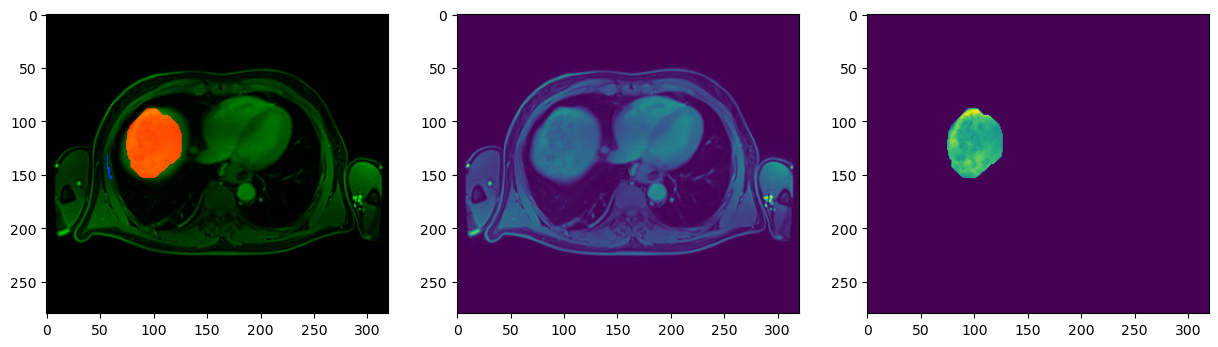

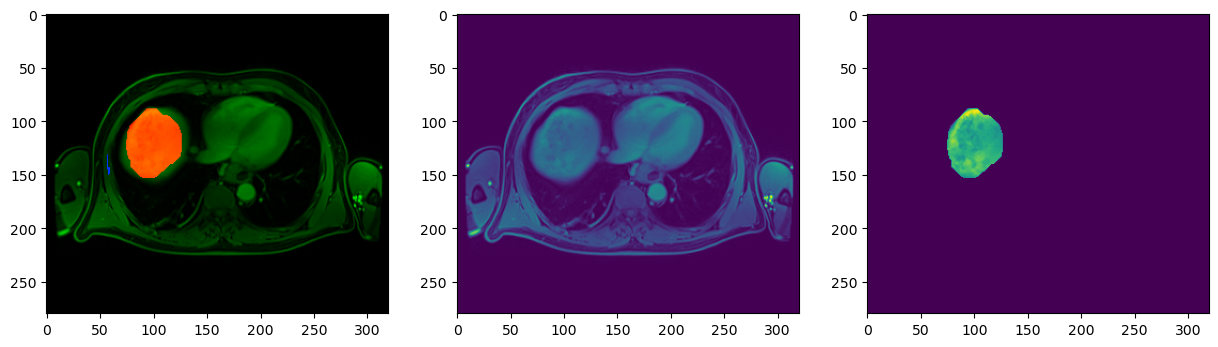

In [49]:
li = cercle_image_compos_connexe(445,show = True, slice_num= 82)
#li = cercle_image_compos_connexe(273,show = True)

In [14]:
def test_filtre():
    image_num = 8
    size = 5

    slice_num = get_good_slice(ls_image[image_num])
    image_name = ls_image[image_num]
    image = sitk.ReadImage(image_name)
    name_mask = image_name.replace('_NAT','').replace('.nii','_masked.nii')
    mask = sitk.ReadImage(name_mask)
    slice_good = sitk.GetArrayFromImage(image[:,:,slice_num])
    filtered = rescale_image_float(slice_good).astype(np.float32)

    mean = nd.uniform_filter(filtered, size)
    mean_sq = nd.uniform_filter(filtered**2, size)
    variance = (mean_sq - mean**2)
    #variance = nd.uniform_filter((filtered - mean)**2, size)
    print(np.quantile(variance,0.95))
    plt.figure(figsize = (15,5))
    plt.subplot(1, 2, 1)
    plt.imshow(variance)
    plt.subplot(1, 2, 2)
    plt.imshow(filtered)

### Généralisation

In [15]:
def extract_all():
    for i, image_name in tqdm.tqdm(enumerate(ls_image)):
        good_slices  = get_all_good_slices(image_name)
        for slice_num in good_slices:
            #print(good_slices)
            mask_sain = cercle_image_compos_connexe(i,slice_num)
            nom = image_name.replace('_NAT','_sain').replace('.nii',f'_masked_sain_slice_{slice_num}.npy') 
            np.save(nom, mask_sain)
            
            
            
        

In [43]:
extract_all()

216it [02:39,  1.32it/s]

echec mask vide image 215 slice 69


269it [03:11,  2.22it/s]

echec mask vide image 268 slice 57


275it [03:17,  1.28it/s]

echec mask vide image 274 slice 20
echec mask vide image 274 slice 21
echec mask vide image 274 slice 22


276it [03:17,  1.49it/s]

echec mask vide image 275 slice 19
echec mask vide image 275 slice 20


325it [03:52,  2.24it/s]

echec mask vide image 324 slice 60
echec mask vide image 324 slice 61
echec mask vide image 324 slice 62


326it [03:52,  2.06it/s]

echec mask vide image 325 slice 61


327it [03:53,  1.91it/s]

echec mask vide image 326 slice 62


358it [04:09,  3.13it/s]

echec mask vide image 358 slice 20
echec mask vide image 358 slice 21
echec mask vide image 358 slice 22
echec mask vide image 358 slice 24
echec mask vide image 358 slice 25
echec mask vide image 358 slice 26
echec mask vide image 358 slice 27


359it [04:10,  2.89it/s]

echec mask vide image 359 slice 17
echec mask vide image 359 slice 18
echec mask vide image 359 slice 19
echec mask vide image 359 slice 20
echec mask vide image 359 slice 21
echec mask vide image 359 slice 23
echec mask vide image 359 slice 24
echec mask vide image 359 slice 25


360it [04:10,  2.79it/s]

echec mask vide image 360 slice 17
echec mask vide image 360 slice 18
echec mask vide image 360 slice 19


361it [04:11,  2.62it/s]

echec mask vide image 361 slice 17
echec mask vide image 361 slice 18
echec mask vide image 361 slice 19
echec mask vide image 361 slice 21
echec mask vide image 361 slice 22
echec mask vide image 361 slice 23
echec mask vide image 361 slice 24


399it [04:29,  1.50it/s]

echec mask vide image 399 slice 18


401it [04:30,  1.83it/s]

echec mask vide image 401 slice 21


433it [04:45,  3.75it/s]

echec mask vide image 432 slice 65
echec mask vide image 432 slice 66
echec mask vide image 432 slice 67
echec mask vide image 432 slice 68


443it [04:49,  1.55it/s]

echec mask vide image 442 slice 83
echec mask vide image 442 slice 86
echec mask vide image 442 slice 87


444it [04:50,  1.19it/s]

echec mask vide image 443 slice 83
echec mask vide image 443 slice 84
echec mask vide image 443 slice 86
echec mask vide image 443 slice 87


445it [04:52,  1.03it/s]

echec mask vide image 444 slice 83
echec mask vide image 444 slice 84
echec mask vide image 444 slice 85


446it [04:53,  1.08s/it]

echec mask vide image 445 slice 85
echec mask vide image 445 slice 86
echec mask vide image 445 slice 87


521it [06:08,  2.68it/s]

echec mask vide image 520 slice 57


534it [06:12,  2.32it/s]

echec mask vide image 533 slice 73


537it [06:13,  2.51it/s]

echec mask vide image 535 slice 76


550it [06:18,  1.45it/s]


58


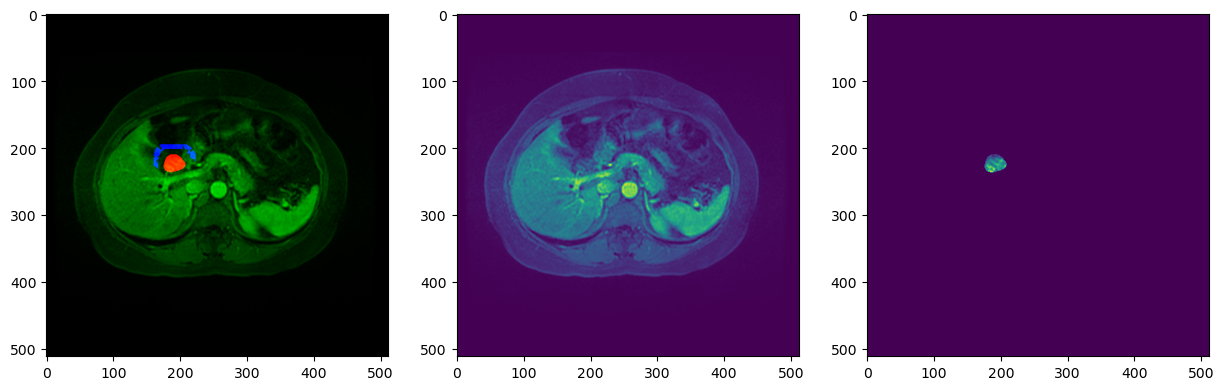

In [671]:
image_name = ls_image[5]
mask_sain_name_incomplet = image_name.replace('_NAT','_sain').replace('.nii',f'_masked_sain_slice_') 
ls_mask_sain_for_image_i = sorted(glob.glob(mask_sain_name_incomplet + '*'))
mask_sain_name = ls_mask_sain_for_image_i[0]
slice_num = int(mask_sain_name.split('_')[-1].replace('.npy',''))
mask_sain = np.load(mask_sain_name)
mask_superpose(5, slice_num = slice_num, other_mask = mask_sain)
print(slice_num)

